# Bootstrapping to estimate parameter ranges of nonlinear models

When we first introduced ourselves to regression, we focused the regression algorithm’s ability to find the “truth”, i.e. how close to the true parameter values does the algorithm get.

In statistics and boostrapping, the truth is (typically) unknown and there is noise associated with any given measurement. So our question becomes “how confident am I that the parameters of my model are not zero?” And as discussed in class, all kinds of challenges arise when using bootstrapping. Here, we'll try a simple example.

Let's consider one of our equations for bacterial growth:
\begin{align}
\dot{y} = \frac{y^3}{a+y^3}-by
\end{align}

where y is the concentration of bacterium and a and b are parameters that help define the rate of bacterial growth and loss, respectively. 

You have been provided with data, called "Homework11 Data.csv". Use this data for the following excercises. In this file, you'll find the time points sampled and the concentration of bacterium (y) for 5 independent experiments. We will consider data to be independent across time and experiments.

## Part 1: Plot data and perform initial fitting

In the space below, load the data and write the code to fit the parameters of our model to the data using minimize or fsolve. You may want to revisit your previous homeworks. To make things a little easier, I'll give you the first guess for your parameter. Go with (a,b) = (0.3,0.8). After fitting:
   - clearly indicate what were the parameter values and the value of the cost function you implemented.
   - Plot on one plot the data and the fitted model's response

   Time   Exp1   Exp2   Exp3   Exp4   Exp5
0    10   6.20   4.07   8.13   7.97   7.07
1    20   8.84   5.63  10.90  10.90   9.80
2    30   9.99   9.16  11.00   8.80  10.30
3    50  10.80  11.70  10.40  10.60   8.65
My value for a is:  1.5503648489021662
My value for b is:  0.09515348545431213
The value of my cost function, which was a root mean squared error function, after minimization was 0.32910433327559996


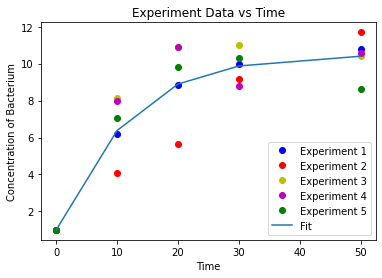

In [82]:
#importing necessary libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import odeint
import scipy.stats as stats

#loading in data
data = pd.read_csv("Homework 6 Data.csv")
print(data)


time = np.append(0, data["Time"])
exp1 = np.append(1, data["Exp1"])
exp2 = np.append(1, data["Exp2"])
exp3 = np.append(1, data["Exp3"])
exp4 = np.append(1, data["Exp4"])
exp5 = np.append(1, data["Exp5"])

inic = 1
    
#define ODE system
def bacteria(dat,t,a,b):
        
    y = dat[0]
        
    #solving
    f = [(y**3)/(a+y**3)-(b*y)]
    return f

    
#define RMSE function
def RMSE(params):
    a,b = params;
    ODE_output = np.transpose(odeint(bacteria,inic, time, args = (a,b)))
    
    #calculating individual errors, dividing by average value
    err1 = (exp1 - ODE_output) / 8.96
    err2 = (exp2 - ODE_output) / 7.64
    err3 = (exp3 - ODE_output) / 10.1
    err4 = (exp4 - ODE_output) / 9.56
    err5 = (exp5 - ODE_output) / 8.65
    
    #combining errors
    err12 = (np.concatenate((err1,err2),axis =0))
    err34 = (np.concatenate((err3,err4),axis =0))
    
    err = np.concatenate((err12,err34),axis = 0)
    err = np.concatenate((err,err5),axis = 0)
    
    return np.sqrt(np.sum(err**2)/5) 

solution1 = minimize(RMSE, x0=(0.3,0.8))
#print(solution1)
ODE_output = odeint(bacteria,inic , time, args = (solution1.x[0],solution1.x[1]))

print('My value for a is: ',solution1.x[0])
print('My value for b is: ', solution1.x[1])

print('The value of my cost function, which was a root mean squared error function, after minimization was', RMSE([solution1.x[0],solution1.x[1]]))

#plotting training data vs time and labeling everything
plt.plot(time,exp1,'bo',label='Experiment 1')
plt.plot(time,exp2,'ro',label='Experiment 2')
plt.plot(time,exp3,'yo',label='Experiment 3')
plt.plot(time,exp4,'mo',label='Experiment 4')
plt.plot(time,exp5,'go',label='Experiment 5')
plt.plot(time,ODE_output,label="Fit")
plt.xlabel('Time')
plt.ylabel('Concentration of Bacterium')
plt.title("Experiment Data vs Time")
plt.legend()

## Part 2: Use sampling with replacement to create distributions of parameters that fit the data

Our hypothesis is that both a and b are greater than 0. Use the bootstrap method to create distributions of estimates of our parameter values. We can do this by, **for each iteration:**
   - Resample the data at each time point using sample with replacement (search online how to do).
   - Use minimize to refit the model to the resampled data
   - Save the fitted parameter estimates and the value of the cost function.
   
Do this for at least 200 iterations. HINT: this code may take a long time to run. It would be best to get the code working with only a few iterations. And once happy, then try 200. After completing, plot histograms of the fitted parameter values and cost function values. Figures must be clearly labeled and obvious to read. 

Based on these data, what is the p value for the null hypothesis that a and b are equal to zero? Calculate the one sided p value, based on the idea that we expect them to be greater than zero.
   

In [83]:
#setting number of iterations and initializing variables
N = 250
rootmean = np.ones(N)
boot_a = np.ones(N)
boot_b = np.ones(N)

#loop!
for m in np.arange(0,N,1):
    choice1 = np.random.choice(data.iloc[0,1:])
    choice2 = np.random.choice(data.iloc[1,1:])
    choice3 = np.random.choice(data.iloc[2,1:])
    choice4 = np.random.choice(data.iloc[3,1:])
    newsample = [1,choice1,choice2,choice3,choice4]
    
    def RMSE(params):
        a,b = params
        ODE_output = np.transpose(odeint(bacteria,inic,time,args=(a,b)))
        err = (newsample-ODE_output)/np.mean(newsample)
        return np.sqrt(np.sum(err**2))
    
    solution = minimize(RMSE, x0 = (0.3,0.8))
    
    boot_a[m] = solution.x[0]
    boot_b[m] = solution.x[1]
    rootmean[m] = RMSE([solution.x[0],solution.x[1]])

C:\Users\pooja\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\pooja\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\pooja\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


The p-value of "a" not being 0 based on the distribution is  0.7919865104758861
The p-value of "b" not being 0 based on the distribution is  0.8357037933385147


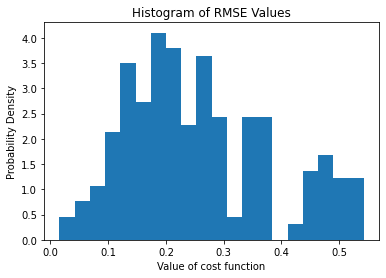

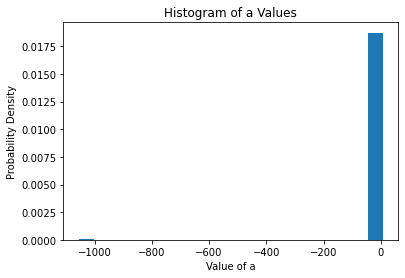

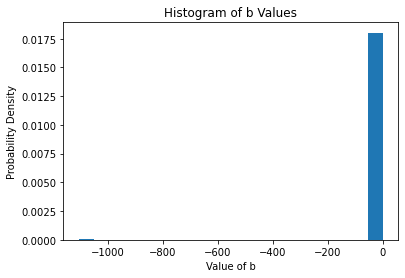

In [84]:
#plotting histograms
plt.figure()
plt.hist(rootmean,density = True,bins=20)
plt.xlabel('Value of cost function')
plt.ylabel('Probability Density')
plt.title('Histogram of RMSE Values')

plt.figure()
plt.hist(boot_a,density = True, bins=20)
plt.xlabel('Value of a')
plt.ylabel('Probability Density')
plt.title('Histogram of a Values')

plt.figure()
plt.hist(boot_b,density = True,bins=20);
plt.xlabel('Value of b')
plt.ylabel('Probability Density')
plt.title('Histogram of b Values');

t1,p1 = stats.ttest_1samp(boot_a,0, alternative="greater")
t2,p2 = stats.ttest_1samp(boot_b,0, alternative="greater")

print('The p-value of "a" not being 0 based on the distribution is ',p1)
print('The p-value of "b" not being 0 based on the distribution is ', p2)

## Part 3 Analyze fit results

One a single figure, plot the model's response vs time for all 200 estimates of the parameter values. Are the fits reasonable? Should any of the fits be discounted? Why so? Does this change how you define your p values above? **Defend your answer here and include any plots as necessary:**

<font color=red>All of the fits look really similar to the original fit. They all seem to lie in between the range of the original data. There are one or two that do not follow the trend of the rest of the fits and I would probably discount those ones. I don't think this should change how I defined my p values above.</font>


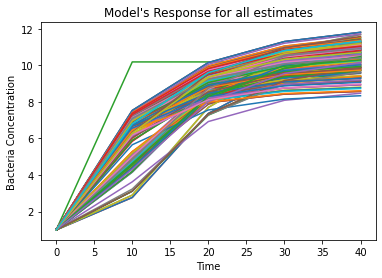

In [85]:
solutions = np.ones((N,5))
time1 = np.arange(0,50,10)

for m in np.arange(0,N,1):
    solutions[m,:] = np.transpose(odeint(bacteria,inic,time1,args = (boot_a[m],boot_b[m])))
    plt.plot(time1, solutions[m,:])
    plt.ylabel('Bacteria Concentration')
    plt.xlabel('Time')
    plt.title("Model's Response for all estimates")

<h1> Project Information</h1>
<ul>
    <li>Measurement to be analyzed: Death rates</li>
    <li>Factor 1: Presence of multigenerational households</li>
    <li>Factor 2: Households receiving food stamps</li>
</ul>